In [50]:
import os
import warnings
import researchpy
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt

from scipy.stats import skew, kurtosis 

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
%matplotlib inline

In [32]:
def estatisticas(df):
    """
    Calcula algumas estatísticas descritivas sobre as variáveis numéricas de uma base de dados.
    É apenas uma incrementação do método describe() da biblioteca pandas.
    """
    
    d = df.describe(include='all')
    d.loc['skewness'] = skew(df)
    d.loc['kurtosis'] = kurtosis(df)
    
    return d

## Etapa 1 - Obtain/Obtenção

Nesse caso em específico, a obtenção é simples, pois basta carregar a base de dados já fornecida na competição. Em contextos reais, é comum precisar realizar *web scraping*, que consiste em uma raspagem/coleta dos dados brutos diretamente de algum site. ou outra fonte

In [16]:
# Pegando o caminho absoluto dos dados
ROOT_DIR = os.path.abspath(os.curdir)
DATA_DIR = ROOT_DIR + '\data\data_ru.csv'

df = pd.read_csv(DATA_DIR, sep = ';')

In [17]:
# Visão geral da base de dados
df.head()

,date,lunch,dinner
0,2016-01-04,364,294
1,2016-01-05,489,363
2,2016-01-06,522,401
3,2016-01-07,514,349
4,2016-01-08,409,218


## Etapa 2 - Scrub/Limpeza

In [18]:
# Visão geral sobre os tipos de dados de cada coluna
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    1095 non-null   object
 1   lunch   1095 non-null   int64 
 2   dinner  1095 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 25.8+ KB


In [20]:
#corrigindo o tipo de dados da coluna date para o tipo datetime, que é mais adequado para análise de séries temporais
df['date'] = pd.to_datetime(df['date'])

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1095 non-null   datetime64[ns]
 1   lunch   1095 non-null   int64         
 2   dinner  1095 non-null   int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 25.8 KB


In [30]:
#checando por dados duplicados
df.duplicated().sum()

0

In [31]:
#checando por dados faltantes
df.isnull().sum()

date      0
lunch     0
dinner    0
dtype: int64

## Etapa 3 - Explore/Exploração
Na etapa de exploração, são realizadas verificações estatísticas sobre os dados para que haja a formulação de hipóteses sobre eles. Estamos lidando com uma base de pequeno porte, já bem preparada, então a análise se torna bem mais simples.

### 3.1. Análise descritiva

In [82]:
#fazendo uma cópia da base original para realizar alterações
df1 = df.copy()

In [83]:
#criando uma nova variável para representar o total de refeições em um dia
df1['total_refeicoes'] = df1['lunch'] + df1['dinner']

In [85]:
#Ambas variáveis são numéricas, então checamos pela distribuição.
features = df1.drop('date', axis = 1).columns

estatisticas(df1[features])

,lunch,dinner,total,total_refeicoes
count,1095.000000,1095.000000,1095.000000,1095.000000
mean,519.748858,308.515982,828.264840,828.264840
std,312.016585,226.023003,534.150505,534.150505
min,0.000000,0.000000,0.000000,0.000000
25%,175.500000,0.000000,176.500000,176.500000
50%,646.000000,387.000000,1046.000000,1046.000000
75%,781.000000,503.000000,1281.000000,1281.000000
max,1033.000000,714.000000,1720.000000,1720.000000
skewness,-0.432858,-0.342741,-0.396149,-0.396149
kurtosis,-1.333381,-1.485497,-1.436612,-1.436612


Através das estatísticas _skewness_ (assimetria) e _kurtosis_ (curtose) podemos chegar às seguintes conclusões:

**Sobre assimetria**:
- Ambas variáveis apresentam uma assimetria ***negativa***, ou seja, os dados estão mais concentrados ***acima*** da média.

**Sobre curtose**:
- Ambas as variáveis apresentam um valor de curtose **menor que 3**, ou seja, a curva da distribuição é mais "achatada". Isso significa que os dados estão bem distribuídos.

### 3.2. Hipóteses

Agora, criamos algumas hipóteses em relação aos dados para tentar validá-las.

**Hipótese 1.** Uma grande parte dos estudantes universitários voltam para suas cidades de origem na sexta-feira, então, na sexta-feira são realizadas MENOS refeições.

**Hipótese 2.** Alguns estudantes não chegam exatamente na segunda-feira, então são realizadas MENOS refeições, mas com uma diferença menor do que na sexta-feira.

**Hipótese 3.** Nos meses imediatamente anteriores às férias, são realizadas MENOS refeições.

**Hipótese 4.** O total de refeições aumentou ao passar dos anos.

In [102]:
#criando novas variáveis para facilitar a análise

#ano
df1['year'] = df1['date'].dt.year

#mês
df1['month'] = df1['date'].dt.month

#dia do mês 
df1['day'] = df1['date'].dt.day

#dia da semana. Da documentação do python, sobre a função weekday: 
"""
Return the day of the week as an integer, where Monday is 0 and Sunday is 6.
"""

df1['weekday'] = df1['date'].dt.weekday

dias_da_semana = {
    0: 'Segunda-feira',
    1: 'Terça-feira',
    2: 'Quarta-feira',
    3: 'Quinta-feira',
    4: 'Sexta-feira',
    5: 'Sábado',
    6: 'Domingo'
}

meses = {
    1: 'Janeiro',
    2: 'Fevereiro',
    3: 'Março',
    4: 'Abril',
    5: 'Maio',
    6: 'Junho',
    7: 'Julho',
    8: 'Agosto',
    9: 'Setembro',
    10: 'Outubro',
    11: 'Novembro',
    12: 'Dezembro'
}

**Hipótese 1.** Na sexta-feira são realizadas MENOS refeições.

**Hipótese 2.** Na segunda-feira são realizadas MENOS refeições.

In [101]:
#média de refeições por dia
mean_by_weekday = df1.groupby('weekday').mean()[['lunch', 'dinner', 'total_refeicoes']]
mean_by_weekday.rename(dias_da_semana, axis=0, inplace=True)

mean_by_weekday

,lunch,dinner,total_refeicoes
weekday,,,
Segunda-feira,495.642202,331.486239,827.128440
Terça-feira,583.289593,348.393665,931.683258
Quarta-feira,566.515982,336.301370,902.817352
Quinta-feira,532.246575,312.305936,844.552511
Sexta-feira,419.903670,213.399083,633.302752


Como podemos ver, em média, na sexta-feira realmente são feitas menos refeições, então a hipótese 1 é **verdadeira.**

Também podemos ver que, em média, na segunda-feira são realizadas menos refeições, mas essa diferença é bem pequena. Assim, a hipótese 2 também é **verdadeira.**

Além disso, chegamos a outras observações interessantes: 

- Na segunda, se comparada aos outros dias da semana (fora a sexta), a diferença da quantidade de refeições no almoço é bem maior que a diferença de refeições no jantar. Isso pode se dar ao fato de que há muitos estudantes que chegam de suas cidades de origem na segunda, mas não a tempo do almoço.

- Na sexta, são feitas muito menos refeições no jantar do que no almoço, quase metade. Isso pode se dar ao fato de que alguns estudantes têm aula durante o dia, e vão embora apenas à tarde ou à noite.

**Hipótese 3.** Nos meses imediatamente anteriores às férias, são realizadas MENOS refeições.

In [123]:
#média de refeições por mês
mean_by_month = df1.groupby('month').mean()[['lunch', 'dinner', 'total_refeicoes']]
mean_by_month.rename(meses, axis=0, inplace=True)

#porcentagem que cada mês representa em relação ao total da média de refeições no ano
mean_by_month.loc[:, 'porcentagem'] = mean_by_month.loc[:, 'total_refeicoes'] / mean_by_month.sum()['total_refeicoes']
mean_by_month['porcentagem'] = mean_by_month['porcentagem'].map(lambda x: '{:,.2%}'.format(x))

mean_by_month

,lunch,dinner,total_refeicoes,porcentagem
month,,,,
Janeiro,197.757009,71.158879,268.915888,2.66%
Fevereiro,306.378947,127.789474,434.168421,4.30%
Março,528.567568,321.576577,850.144144,8.42%
Abril,684.833333,424.488095,1109.321429,10.98%
Maio,701.175824,441.714286,1142.890110,11.31%
Junho,665.823529,411.176471,1077.000000,10.66%
Julho,254.448276,106.367816,360.816092,3.57%
Agosto,622.021978,367.527473,989.549451,9.80%
Setembro,746.500000,489.642857,1236.142857,12.24%


Text(0.5, 1.0, 'Média de refeições por mês')

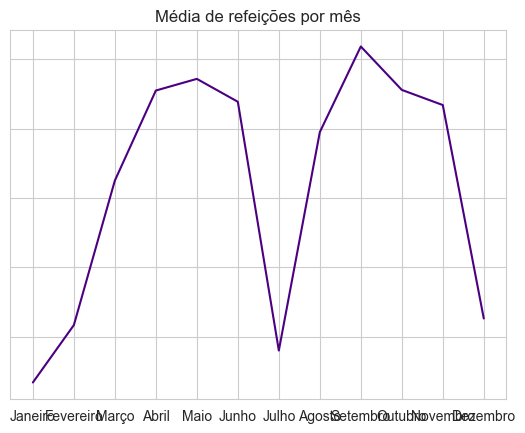

In [131]:
#visualizando a informação
sns.lineplot(mean_by_month['total_refeicoes'], color='indigo').set(xlabel=None,
                                                                   ylabel=None,
                                                                   yticklabels=[])
plt.title('Média de refeições por mês')

As férias geralmente iniciam nos meses de julho e dezembro, então o esperado era que houvesse menos refeições nos meses de junho e outubro, porém observamos que isso não acontece. Sendo assim, a hipótese 3 é FALSA.

Porém, também chegamos a informações interessantes:
- Nas férias, realmente verificamos que há menos refeições, então constatamos que, para essa informação, a base não tem inconsistência.
- No primeiro mês de aula do semestre (geralmente março e agosto), são realizadas menos refeições.

**Hipótese 4.** O total de refeições aumentou ao passar dos anos.

In [128]:
#média de refeições por ano
mean_by_year = df1.groupby('year').mean()[['lunch', 'dinner', 'total_refeicoes']]

mean_by_year
#sns.lineplot(mean_by_year['total_refeicoes'])

,lunch,dinner,total_refeicoes
year,,,
2016,500.984252,311.740157,812.724409
2017,527.176923,316.057692,843.234615
2018,517.669231,299.738462,817.407692
2019,582.104247,344.934363,927.038610
2020,313.709677,148.354839,462.064516


In [ ]:
#verificando visualmente a informação

## Etapa 4 - Model/Modelagem

## Etapa 5 - Interpret/Interpretação